In [69]:
import time 
import numpy as np
import pandas as pd
from scipy import signal
import csv
import os
from datetime import datetime
import matplotlib.pyplot as plt
from numpy.fft import rfft, irfft

import torch
import torch.nn as nn
import torch.distributed as dist
import torch.multiprocessing as mp
from torch.utils.data import Dataset, DataLoader
from torch.utils.data.distributed import DistributedSampler
from fft_conv_pytorch import fft_conv, FFTConv1d
torch.backends.cudnn.benchmark = True
torch.backends.cudnn.enabled = True

In [124]:
def init_process(rank, size, backend='nccl'):
    os.environ["MASTER_ADDR"] = "192.168.1.174"
    os.environ["MASTER_PORT"] = "30000"
    dist.init_process_group(backend = backend,
                            init_method ="env://",
                            world_size = size,
                            rank = rank
                           )

class FilterBank(nn.Module):
    def __init__(self,input_channel,num_filters,filter_length,weights = None,stride = 1,norm = None):
        super().__init__()
        self.conv = nn.Conv1d(input_channel,num_filters,filter_length,padding = 0,stride = stride,bias = False)

    def forward(self, x):
        output = self.conv(x)
        return output

class SigData(Dataset):
    def __init__(self, data, fs):
        self.x_delta = 1/fs # define sample time between points
        self.data = data
    def __getitem__(self, index):
        data = self.data.cpu().numpy()
        x = torch.from_numpy(data.reshape((1, -1))).float()
        y = torch.arange(0, len(data))
        return x, y, index
    def __len__(self):
        return int(self.size)    
    
def z_transform(x):
    m = torch.mean(x, 2).unsqueeze_(2)
    s = torch.std(x, 2).unsqueeze_(2)
    return torch.abs((x - m) / s )

def db_transform(x):
    x = torch.abs(x)
    m = torch.mean(x)
    return 20 * torch.log10(x / m)

def inference(model, dataloader, device, out_dir, filter_time_dict, x_delta=1, detection=z_transform, threshold=4, stride=1):
    model = model.to(device)
    for inputs, indices, index in dataloader:
        with torch.no_grad():
            inputs = inputs.to(device)
            indices = indices.to(device)
            outputs = model(inputs)
            end = int(outputs.shape[-1] * stride)
            indices = indices[:, :end:stride]
            outputs = detection(outputs)
            mask = outputs.ge(threshold)
            values = torch.nonzero(mask)
        outputs = outputs[values[:, 0], values[:, 1], values[:, 2]].data.cpu().numpy()
        filters = values[:, 1].data.cpu().numpy()
        indices = indices[0][values[:, 2]].data.cpu().numpy()
        filter_time_add = np.zeros(filters.shape[0])
        for f in np.unique(filters):
            idx = np.where(filters == f)
            filter_time_add[idx] = filter_time_dict[int(f)] // 2
        toa = (indices + filter_time_add) * x_delta
        write_results_df(toa, outputs, filters, out_dir, index)
    return

def upsample_old(x, os_factor):
    out = np.zeros((int(len(x)*os_factor)))
    for i in enumerate(x):
        if i[1] == '1':
            if i[0] == len(x):
                out[int(np.round(i[0]*os_factor,0)):] = 1
            else:
                out[int(np.round(i[0]*os_factor,0)):int(np.round((i[0]+1)*os_factor,0))] = 1 
        return out

def upsample(x, os_factor):
    # recall: os_factor is either ratio of sampling frequency and carrier frequency (fs/fc), 
    # or ratio of bit period (1/bitrate) to sample period (1/fs) - (fs*minbit) for basebanded waveform
    codeArr = np.zeros(len(x))
    for i in enumerate(x):
        if i[1]=='1':
            codeArr[i[0]] = 1    
    bipolCodeArr = codeArr*2-1
    out = np.repeat(codeArr,os_factor)
    return out

def dirac_comb(pw,fs,numPeaks,style="peak"):
    """
    Build a dirac comb of pulse length pw to function as a *peaking* comb filter on pulse
    i.e. 0 amplitude almost everywhere, with a value approaching unity in evenly space intervals defined by fs and numPeaks
    This definitely falls apart if the peakspacing does not divide cleanly into the length of the pulse. This makes sense.
    
    Inputs
    ------------------
    pw = desired duration of comb
    fs = sample rate the pulse was produced at (so that comb is produced at same sample rate
    numPeaks = desired number of peaks in the comb
    style = "peak" returns a comb where the teeth are unity and everything else is zero
            "notch" returns a comb where the teeth are 0 and everything else is unity
    
    Outputs
    ------------------
    comb = dirac comb that has NOT been applied to pulse yet
    """
    N = pw*fs # Compute sample size of comb
    N = int(N+1)
    peakSpacing = N/numPeaks 
    peakSpacing = int(peakSpacing) 
    print(f'Sample spacing between the peaks is {peakSpacing} samples')
    
    if style=="notch":
        comb = np.ones(int(N))
        comb[int(peakSpacing/2)::peakSpacing] = 0 # int(peakSpacing/2) shifts valleys to midpoints so that pulse doesn't have discontinuities at end?
    else:
        comb = np.zeros(int(N))
        comb[::peakSpacing] = 1 # int(peakSpacing/2) shifts peaks to midpoints so that pulse doesn't have discontinuities at end?
    return comb

def make_FM_pulse(A, fc, cr, t):
    fmPulse = A*np.exp(1j*np.pi*cr*t*t)*np.exp(1j*2*np.pi*fc*t)
    return fmPulse

def make_BPSK_pulse(A, code, fs, fc, minbit):
    sync = upsample(code, fs*minbit)
    fakeTime = np.arange(0,len(sync))*1/fs
    # For a bpsk pulse this works because pi is 180 degrees, so pi*1 and pi*0 gives a phase difference of 180 degrees, with 180 degrees encoding binary 1, and 0 encoding binary 0
    # What if I shift the phase so that both values are nonzero?
    bpskPulse = A*np.exp(1j*(2*np.pi*fc*(fakeTime+np.pi*sync)))
    return bpskPulse             

# Generate Test Pulse

Sample spacing between the peaks is 100 samples
Signal after comb filter has dims (1001,)
The test has 3001 samples
The pytorch formatted pulse has 3001 samples and total shape torch.Size([1, 1, 3001])


C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


Text(0.5, 1.0, 'Frequency Domain of Pulse Multiplied with Comb')

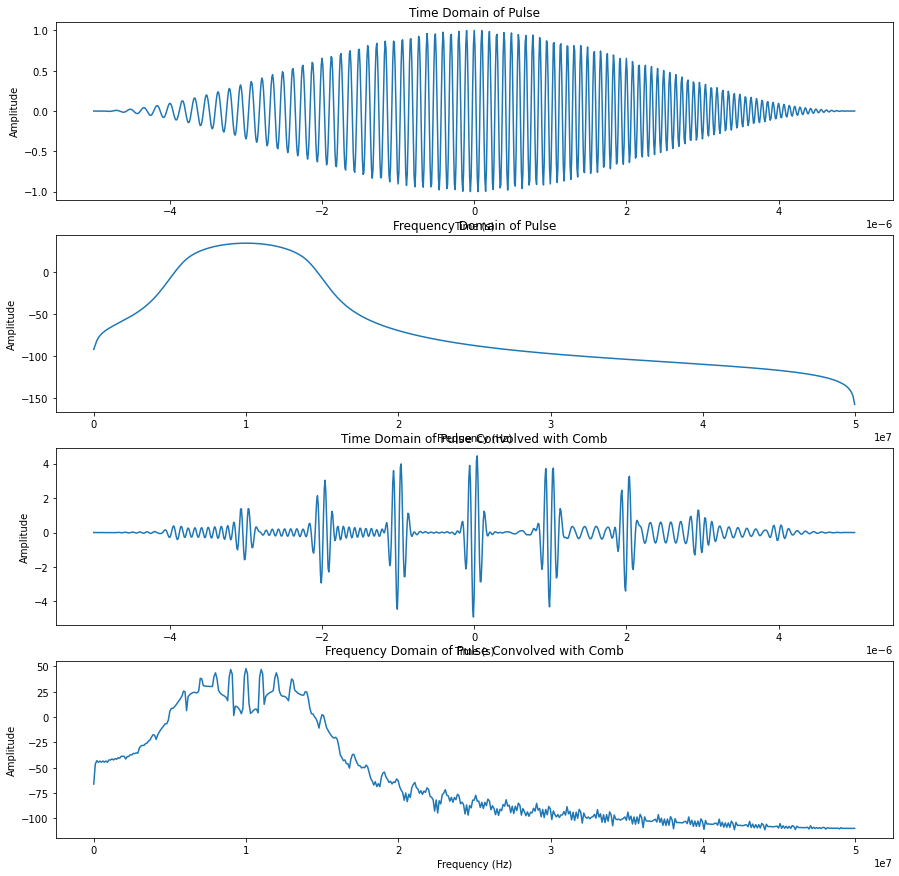

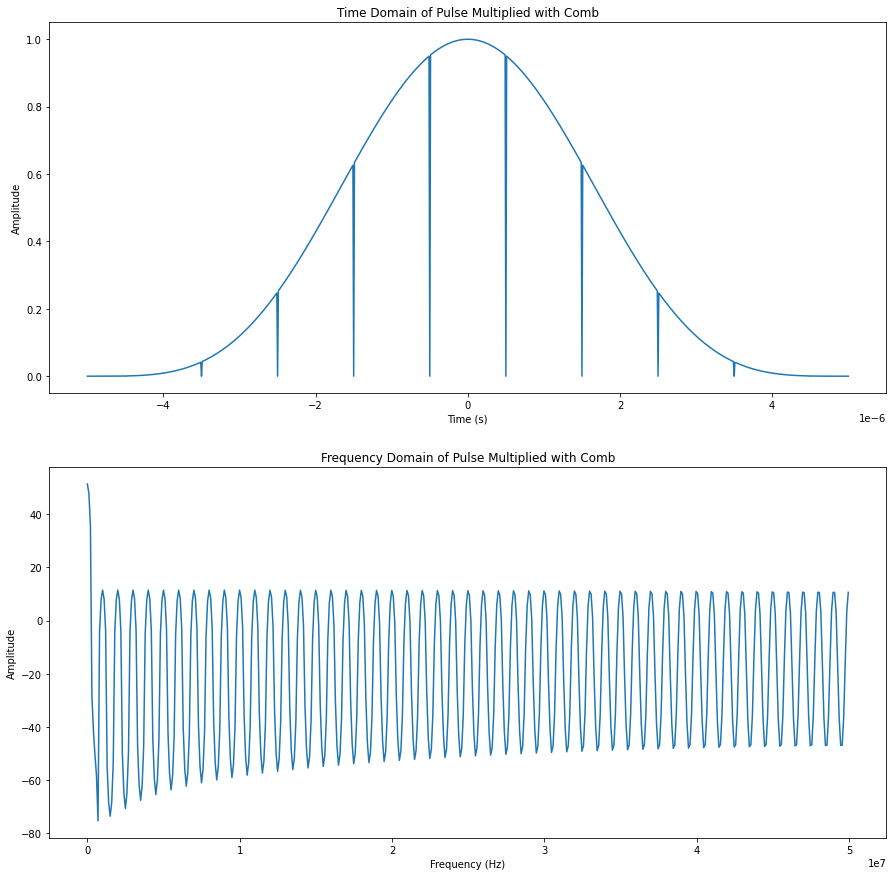

In [138]:
A = 1
fs = 100e6
fc = 10e6
pw = 10e-6
mop = 10e6
N = 1024
cr = mop/pw
t = np.arange(-pw/2, pw/2, 1/fs)
bigT = np.arange(-3*pw/2, 3*pw/2, 1/fs)
raw_sig = make_FM_pulse(A, fc, cr, t)
testPulse = np.hstack(((1/2)*np.random.normal(0,1,len(t)-1),raw_sig + (1/5)*np.random.normal(0,1,len(t)),(1/2)*np.random.normal(0,1,len(t)-1)))
raw_sig = np.multiply(raw_sig,signal.windows.hann(len(raw_sig)))
raw_fft = rfft(raw_sig)
absraw_fft = abs(raw_fft)
freq = np.fft.rfftfreq(raw_sig.shape[-1],d=1/fs)

# So let's think about this a little harder, I need to make a comb that is the length of my filter, with x peaks, spaced at frequency spacings of mop/x
# So the spacing between my peaks is the first value of the comb filter, which is mop/x, for me it's 5e6
comb = dirac_comb(pw,fs,10,style="peak") #but fft of a peak- or notch-style comb is the same.....
# Super cool, where the peak vs notch argument differs is convolving a notch filter versus a peak filter. The peak comb picks the signal out. The notch Filter selected AGAINST the signal
padTest = np.hstack((comb[-1],comb[:-1]))
raw_fft = np.fft.rfft(padTest)
freq = np.fft.rfftfreq(len(t),d=1/fs)
response = abs(raw_fft)
response[response == 0] = 1e-20

mutated_sig = np.multiply(signal.fftconvolve(raw_sig,comb,mode="same"),signal.windows.hann(len(raw_sig)))
print(f'Signal after comb filter has dims {mutated_sig.shape}')
# Also add a bunch of plain noise values on either side. 
print(f'The test has {len(testPulse)} samples')

torchTestSignal = torch.zeros([1,1,len(testPulse)],dtype=torch.cfloat)
torchTestSignal[0,0,:] = torch.complex(torch.tensor(testPulse.real),torch.tensor(testPulse.imag))
print(f'The pytorch formatted pulse has {torchTestSignal.shape[2]} samples and total shape {torchTestSignal.shape}')
freq = np.fft.rfftfreq(raw_sig.shape[-1],d=1/fs)

plt.figure(figsize=(15,15))
plt.subplot(4,1,1)
plt.plot(t,raw_sig.real)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time Domain of Pulse")
plt.subplot(4,1,2)
plt.plot(freq,20*np.log10(abs(rfft(raw_sig))))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain of Pulse")
plt.subplot(4,1,3)
plt.plot(t,mutated_sig.real)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time Domain of Pulse Convolved with Comb")
plt.subplot(4,1,4)
plt.plot(freq,20*np.log10(abs(rfft(mutated_sig))))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain of Pulse Convolved with Comb")

multTest = np.multiply(abs(np.multiply(raw_sig,comb)),signal.windows.hann(len(raw_sig)))

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(t,multTest.real)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time Domain of Pulse Multiplied with Comb")
plt.subplot(2,1,2)
plt.plot(freq,20*np.log10(abs(rfft(multTest))))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain of Pulse Multiplied with Comb")

C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)
C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\numpy\fft\_pocketfft.py:70: ComplexWarning: Casting complex values to real discards the imaginary part
  r = pfi.execute(a, is_real, is_forward, fct)


Text(0.5, 1.0, 'Frequency Domain of Signal Convolved with Multiplied Comb Pulse')

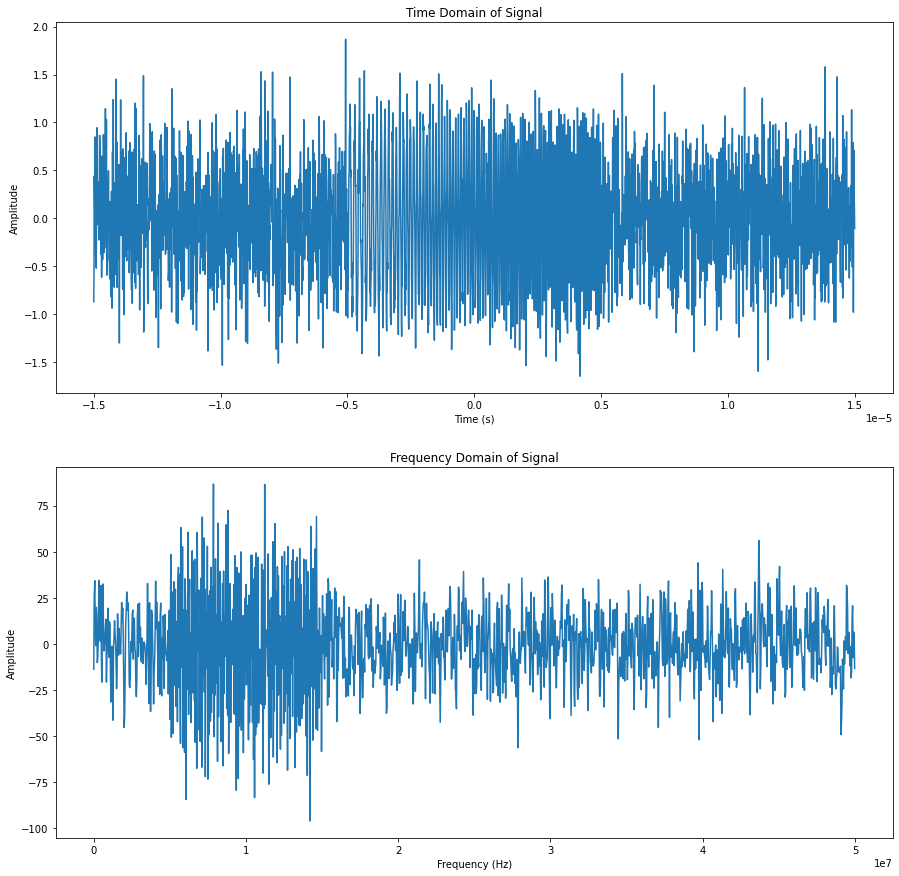

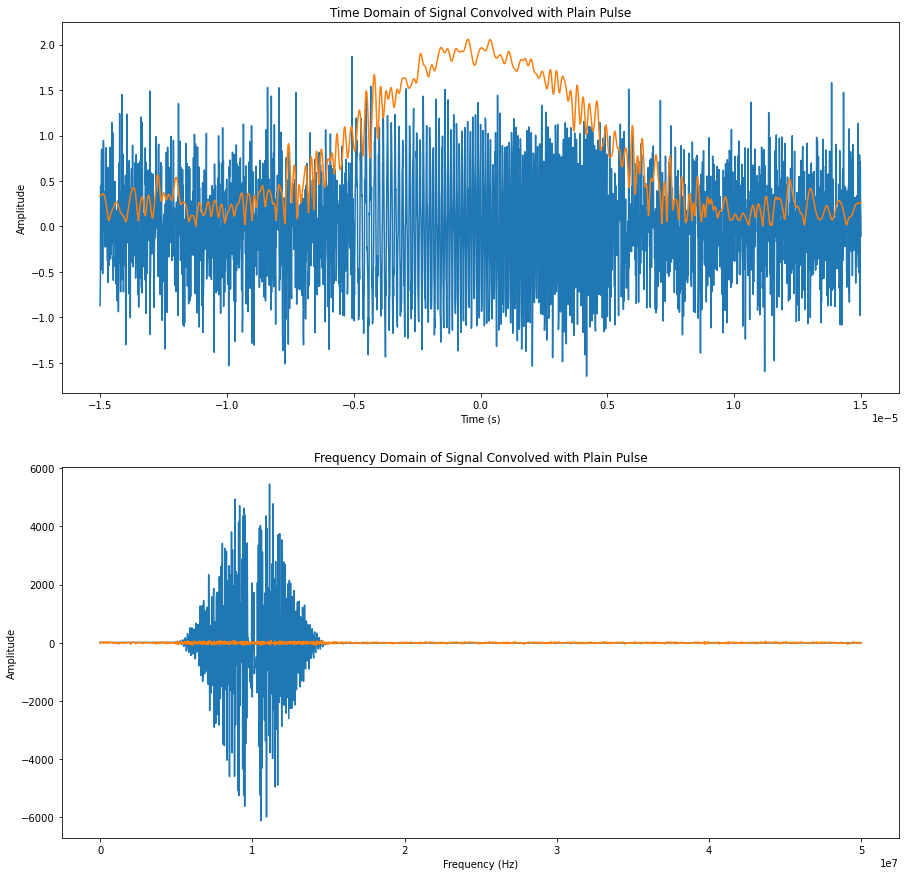

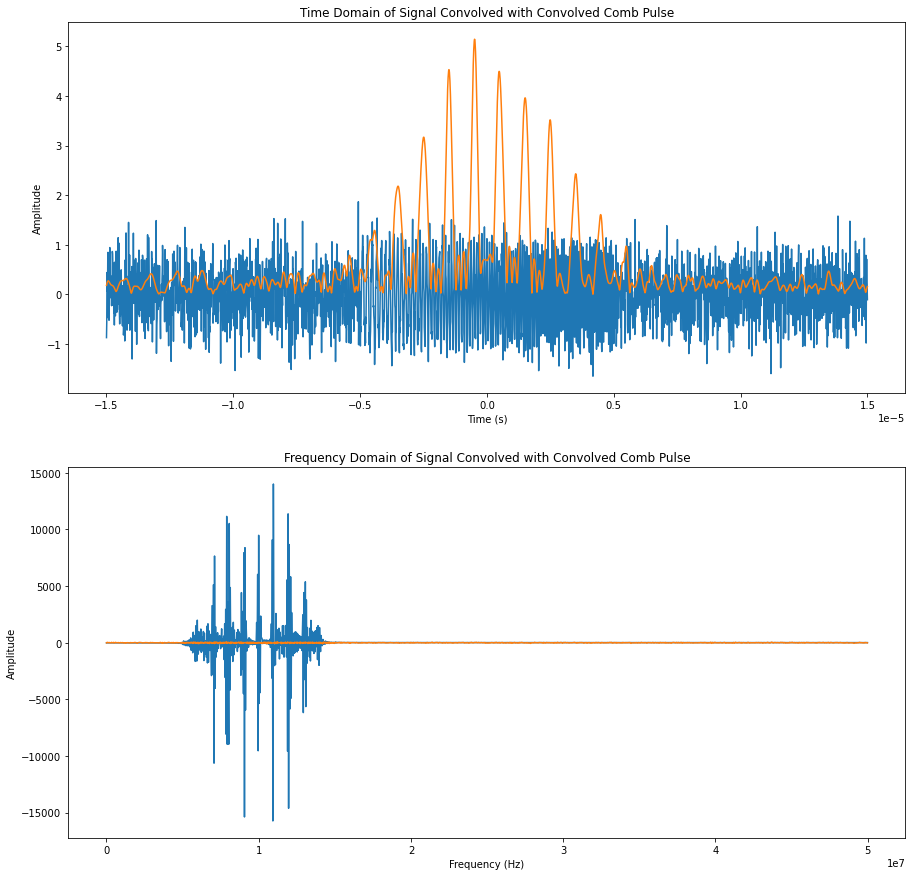

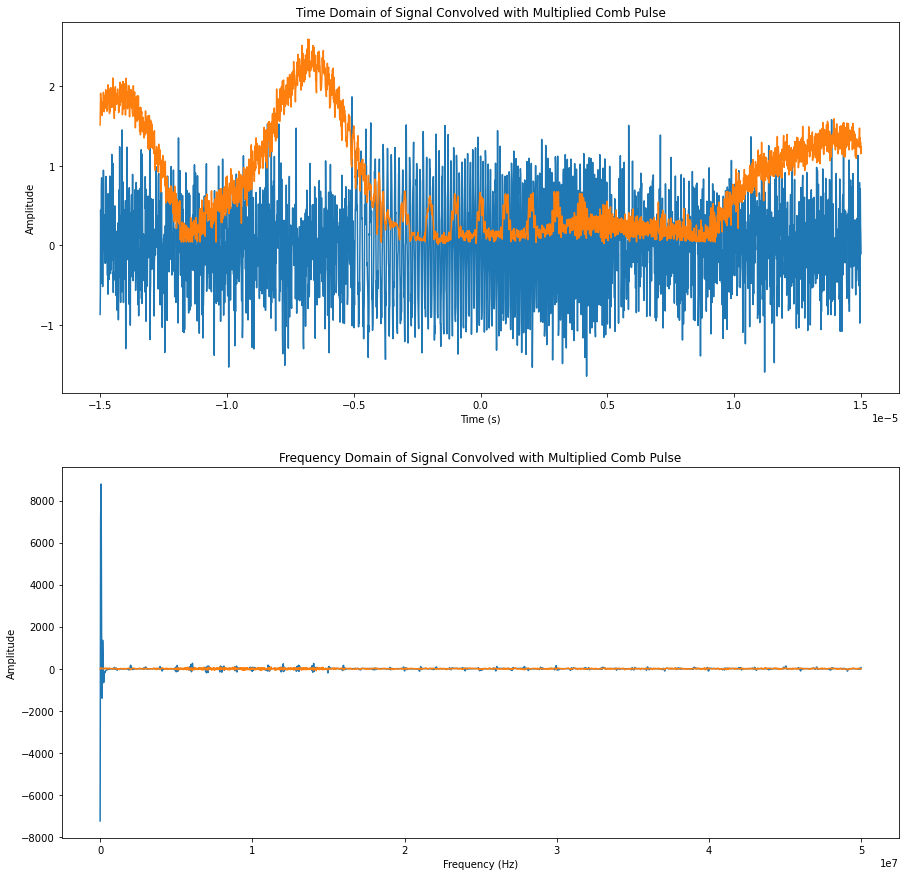

In [139]:
spectrum = rfft(testPulse)
freq = np.fft.rfftfreq(testPulse.shape[-1],d=1/fs)
plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(bigT,testPulse.real)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time Domain of Signal")
plt.subplot(2,1,2)
plt.plot(freq,spectrum.real)
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain of Signal")

final = signal.fftconvolve(testPulse,raw_sig,mode="same")
spectrum = rfft(final)
final = abs(final - np.mean(final))/np.std(final)
freq = np.fft.rfftfreq(testPulse.shape[-1],d=1/fs)

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(bigT,testPulse)
plt.plot(bigT,final)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time Domain of Signal Convolved with Plain Pulse")
plt.subplot(2,1,2)
plt.plot(freq,spectrum)
plt.plot(freq,rfft(testPulse))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain of Signal Convolved with Plain Pulse")

final = signal.fftconvolve(testPulse,mutated_sig,mode="same")
spectrum = rfft(final)
final = abs(final - np.mean(final))/np.std(final)
freq = np.fft.rfftfreq(testPulse.shape[-1],d=1/fs)

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(bigT,testPulse)
plt.plot(bigT,final)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time Domain of Signal Convolved with Convolved Comb Pulse")
plt.subplot(2,1,2)
plt.plot(freq,spectrum)
plt.plot(freq,rfft(testPulse))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain of Signal Convolved with Convolved Comb Pulse")

final = signal.fftconvolve(testPulse,multTest,mode="same")
spectrum = rfft(final)
final = abs(final - np.mean(final))/np.std(final)
freq = np.fft.rfftfreq(testPulse.shape[-1],d=1/fs)

plt.figure(figsize=(15,15))
plt.subplot(2,1,1)
plt.plot(bigT,testPulse)
plt.plot(bigT,final)
plt.xlabel("Time (s)")
plt.ylabel("Amplitude")
plt.title("Time Domain of Signal Convolved with Multiplied Comb Pulse")
plt.subplot(2,1,2)
plt.plot(freq,spectrum)
plt.plot(freq,rfft(testPulse))
plt.xlabel("Frequency (Hz)")
plt.ylabel("Amplitude")
plt.title("Frequency Domain of Signal Convolved with Multiplied Comb Pulse")

# Prep Filter Bank

In [25]:
A = 1
fs = 25e6
fc = 5e6
pw = 10e-6
mop = 5e6
t = np.arange(-pw/2, pw/2, 1/fs)
filterBank = torch.zeros([1,1,len(t)],dtype=torch.cfloat)
pulse = make_FM_pulse(A, fc, cr, t)  # decide later
complexPulse = torch.complex(torch.tensor(pulse.real),torch.tensor(pulse.imag))
filterBank[0,0,:] = complexPulse
    
scipyFilters = filterBank.data.cpu().numpy()
print(f'The filter bank has {scipyFilters.shape[0]} filter(s) that is/are each {scipyFilters.shape[2]} samples long')

The filter bank has 1 filter(s) that is/are each 251 samples long


# Convolve signal with filter bank

In [26]:
# This is predicated that complex 1d convolution produces 4 convolutional outputs: (if [a+bi]*[c+di]) then return (a*c - b*d) + j(a*d+b*c)
# So declare a convolutional MODEL. WIth the nn.conv1d yadda yadda
# Then, call your new model on the input data
def cmplxCnv(sigInput, filterBank):
    iData = sigInput.real 
    qData = sigInput.imag
    
    imodel = FilterBank(1, filterBank.shape[0], filterBank.shape[2], filterBank.real)
    qmodel = FilterBank(1, filterBank.shape[0], filterBank.shape[2], filterBank.imag)
    with torch.no_grad():
        iOut = imodel(iData)-qmodel(qData)
        qOut = imodel(qData)+qmodel(iData)
        iOut = z_transform(iOut)
        qOut = z_transform(qOut)
    return torch.complex(iOut,qOut)

C:\Users\cgzog\anaconda3\envs\PySDR\lib\site-packages\matplotlib\cbook\__init__.py:1289: ComplexWarning: Casting complex values to real discards the imaginary part
  return np.asarray(x, float)


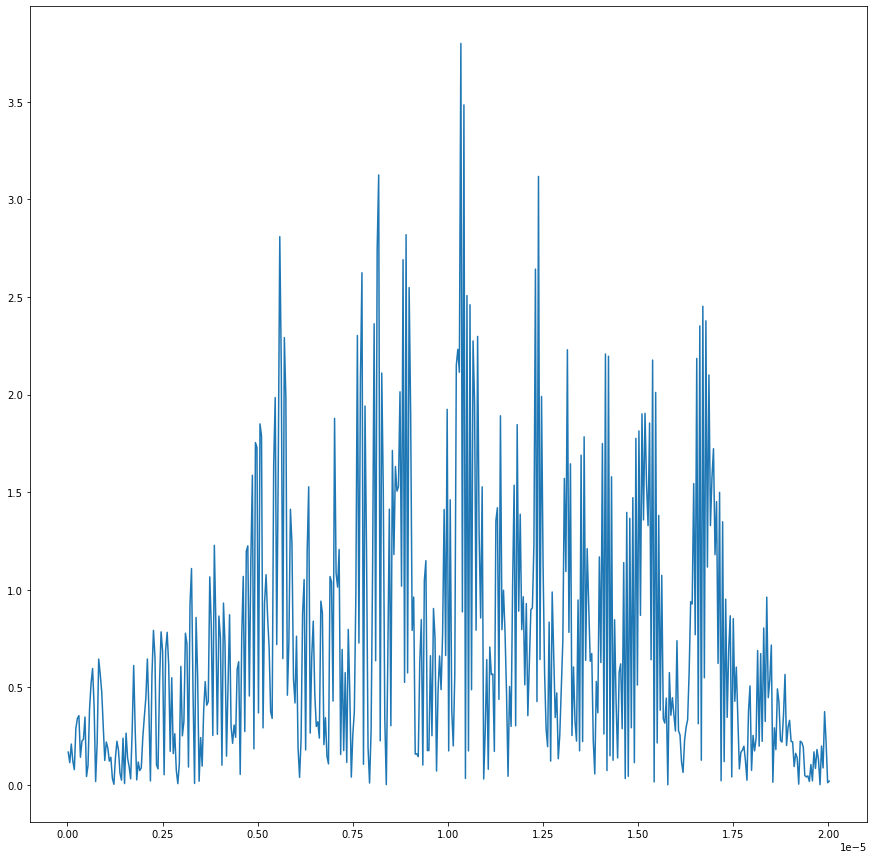

In [27]:
outputs = cmplxCnv(torchTestSignal, filterBank)
# So dimension 0 is indices, which is singleton in this case because I didn't tell it to distribute
# dimension 1 is number of filters
# dimension 2 is the convolutional response per filter
indices = np.arange(0,outputs.shape[2]) + outputs.shape[1]/2
filters = 1 # Yea just gonna set this to 1 
convResp = outputs[:, 0].data.cpu().numpy()
toa = indices * 1/fs

plt.figure(figsize=(15,15))
plt.plot(toa,convResp[0])